# Feature engineering

We start off by importing our libraries. Also, we set one variable to None, because it was causing false positive warnings later in the code.

In [1]:
import pandas as pd
import numpy as np
import scipy
import itertools

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.utils import resample

import xgboost as xgb
import matplotlib.pyplot as plt

/home/szarki/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Now, let's import our dataset into Pandas DataFrame and print out the first five values:

In [2]:
path_data = "./bank-classification.csv"
raw_data  = pd.read_csv(path_data, sep=",")

print(raw_data[:5])

   id  birth_date        job  marital    education  default housing loan  \
0   1  1952-03-23  housemaid  married     basic.4y       no      no   no   
1   2  1951-03-24   services  married  high.school  unknown      no   no   
2   3  1971-05-19   services  married  high.school       no     yes   no   
3   4  1968-01-24     admin.  married     basic.6y       no      no   no   
4   5  1952-05-11   services  married  high.school       no      no  yes   

  contact_date    contact  campaign  pdays  previous     poutcome        y  
0   2008-05-12  telephone         1    999         0  nonexistent       no  
1   2008-05-26  telephone         1    999         0  nonexistent  unknown  
2   2008-05-05  telephone         1    999         0  nonexistent       no  
3   2008-05-19  telephone         1    999         0  nonexistent  unknown  
4   2008-05-19  telephone         1    999         0  nonexistent  unknown  


## Visualization

We will start by visualizing the distribution of our target value

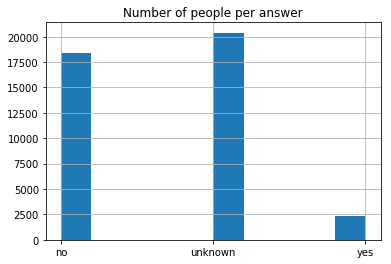

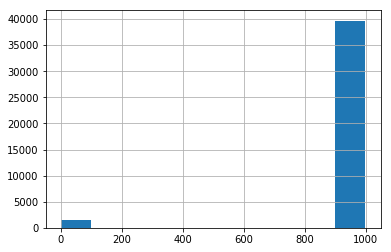

In [3]:
raw_data['y'].hist()
plt.title("Number of people per answer")
plt.show()

raw_data['pdays'].hist()
plt.show()

As we can see, it is highly imbalanced towards the 'no' answer.

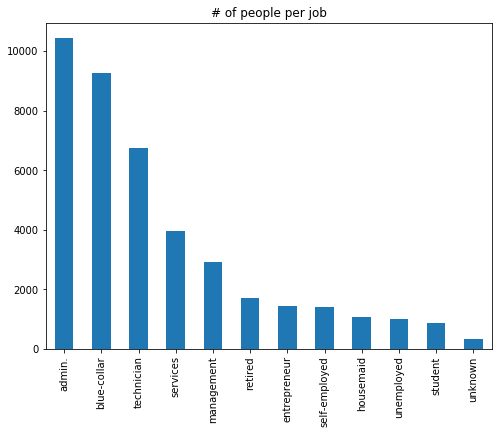

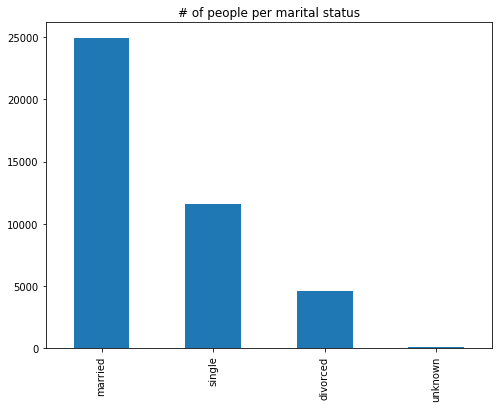

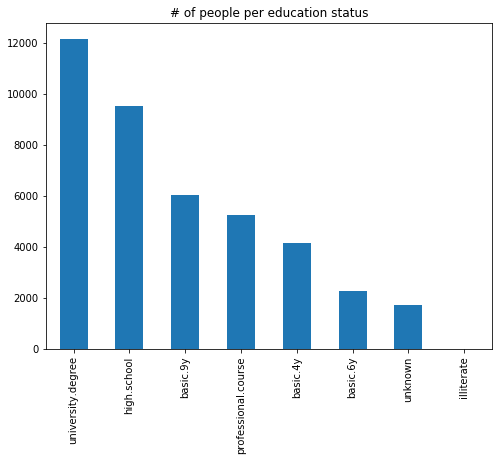

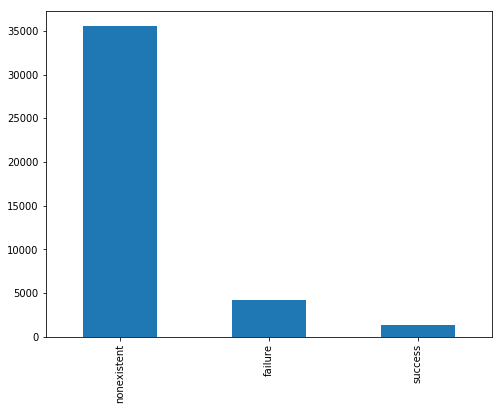

In [4]:
raw_data['job'].value_counts().plot(kind='bar', figsize=(8,6))
plt.title("# of people per job")
plt.show()

raw_data['marital'].value_counts().plot(kind='bar', figsize=(8,6))
plt.title("# of people per marital status")
plt.show()

raw_data['education'].value_counts().plot(kind='bar', figsize=(8,6))
plt.title("# of people per education status")
plt.show()

raw_data['poutcome'].value_counts().plot(kind='bar', figsize=(8,6))
plt.show()

## Preprocessing

In [5]:
data = pd.DataFrame()
data = raw_data

First thing we're going to do is to add extra feature: age of customer when he was contacted.

0    1771545600000000000
1    1804291200000000000
2    1166486400000000000
3    1272326400000000000
4    1767916800000000000
Name: age, dtype: int64


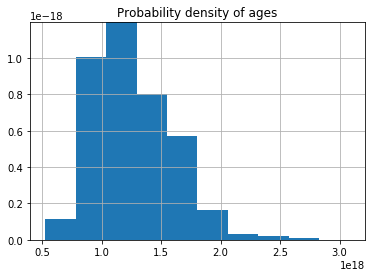

In [6]:
data['age'] = (pd.to_datetime(data['contact_date']) - pd.to_datetime(data['birth_date'])).astype(int)
#timedelta64 is just a 64bit int

print(data['age'][:5])

data['age'].hist(density=True)
plt.title("Probability density of ages")
plt.show()

As of now we won't worry about the representation being in int64, as later we will scale it down to the range [0; 1].

Next we will take care of our dates. We want to be sure that we make the most of them - as in we want our program to be able to know, that December is closer to January than it is to September.

Let's start with splitting the birth date into year, month and day:

In [7]:
def split_date(name):
    data[name + '_year']  = data[name + '_date'].str[:4].astype(int)
    data[name + '_month'] = data[name + '_date'].str[5:7].astype(int)
    data[name + '_day']   = data[name + '_date'].str[8:10].astype(int)
    
    data.drop([name + '_date'], axis=1, inplace=True)

split_date("birth")

As we can cleary see, this format still doesn't capture the cyclical nature of months and days (e.g. 31 day of the month is closer to 1st day of the next month, than it is to 29th of the same month). We'll try to deal with this by splitting both months and days into two another features - based on sin and cos functions.

(Note: code inspired by https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/)

In [8]:
months_in_year = 12
days_in_month  = 31 # we'll assume 31 is the maximum for every month

dates = ['b_year', 'b_sin_month', 'b_cos_month', 'b_sin_day', 'b_cos_day',
         'c_year', 'c_sin_month', 'c_cos_month', 'c_sin_day', 'c_cos_day']

def cyclical_date(name):
    data[name[:1] + '_year'] = data[name + '_year']

    data[name[:1] + '_sin_month'] = np.sin(2 * np.pi * (data[name + '_month'] - 1) / months_in_year)
    data[name[:1] + '_cos_month'] = np.cos(2 * np.pi * (data[name + '_month'] - 1) / months_in_year)

    data[name[:1] + '_sin_day'] = np.sin(2 * np.pi * data[name + '_day'] / days_in_month)
    data[name[:1] + '_cos_day'] = np.cos(2 * np.pi * data[name + '_day'] / days_in_month)

    data.drop([name + '_year', name + '_month', name + '_day'], axis=1, inplace=True)
    
cyclical_date("birth")

split_date("contact")
cyclical_date("contact")

print(data[dates][:5])

   b_year  b_sin_month  b_cos_month  b_sin_day  b_cos_day  c_year  \
0    1952     0.866025          0.5  -0.998717  -0.050649    2008   
1    1951     0.866025          0.5  -0.988468   0.151428    2008   
2    1971     0.866025         -0.5  -0.651372  -0.758758    2008   
3    1968     0.000000          1.0  -0.988468   0.151428    2008   
4    1952     0.866025         -0.5   0.790776  -0.612106    2008   

   c_sin_month  c_cos_month  c_sin_day  c_cos_day  
0     0.866025         -0.5   0.651372  -0.758758  
1     0.866025         -0.5  -0.848644   0.528964  
2     0.866025         -0.5   0.848644   0.528964  
3     0.866025         -0.5  -0.651372  -0.758758  
4     0.866025         -0.5  -0.651372  -0.758758  


By plotting our data we can see, that indeed the cyclical nature of the events was preserved:

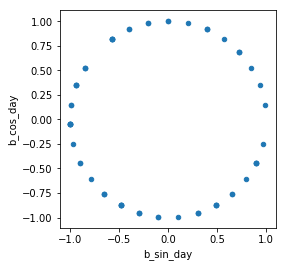

In [9]:
data.sample(70).plot.scatter('b_sin_day','b_cos_day').set_aspect('equal')
plt.show()

Types of columns and splitting them into categorical and numerical values:

In [10]:
data.columns

Index(['id', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'campaign', 'pdays', 'previous', 'poutcome', 'y', 'age',
       'b_year', 'b_sin_month', 'b_cos_month', 'b_sin_day', 'b_cos_day',
       'c_year', 'c_sin_month', 'c_cos_month', 'c_sin_day', 'c_cos_day'],
      dtype='object')

In [11]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome', 'contact']
numerical   = ['b_year', 'age', 'pdays', 'previous', 'campaign']

Next thing we will do is to encode our categorical string values. We will use get_dummies method, because as of now, sklearns One Hot Encoding doesn't work directly on strings (although it is to be added in near future :))

In [12]:
data = pd.get_dummies(data, columns=categorical)

print(data.columns)

Index(['id', 'campaign', 'pdays', 'previous', 'y', 'age', 'b_year',
       'b_sin_month', 'b_cos_month', 'b_sin_day', 'b_cos_day', 'c_year',
       'c_sin_month', 'c_cos_month', 'c_sin_day', 'c_cos_day', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'contact_cellular', 'contact_telephone

After preprocessing dates and strings, we'll take care of numerical values. Due to their sparse nature, we'll be using MinMaxScaler (which scales all the values to a [0; 1] range).

In [13]:
minmax = MinMaxScaler()
data[numerical] = minmax.fit_transform(data[numerical])

Last thing that we need to do, is to transform the target values from yes/no/unknown to 0/1/2

In [14]:
data['y'] = raw_data['y']

data['y'] = data['y'].replace(to_replace="no",      value=0)
data['y'] = data['y'].replace(to_replace="yes",     value=1)
data['y'] = data['y'].replace(to_replace="unknown", value=2)

print(data[:5])

   id  campaign  pdays  previous  y       age    b_year  b_sin_month  \
0   1       0.0    1.0       0.0  0  0.486711  0.493827     0.866025   
1   2       0.0    1.0       0.0  2  0.499510  0.481481     0.866025   
2   3       0.0    1.0       0.0  0  0.250211  0.728395     0.866025   
3   4       0.0    1.0       0.0  2  0.291581  0.691358     0.000000   
4   5       0.0    1.0       0.0  2  0.485293  0.493827     0.866025   

   b_cos_month  b_sin_day        ...          housing_unknown  housing_yes  \
0          0.5  -0.998717        ...                        0            0   
1          0.5  -0.988468        ...                        0            0   
2         -0.5  -0.651372        ...                        0            1   
3          1.0  -0.988468        ...                        0            0   
4         -0.5   0.790776        ...                        0            0   

   loan_no  loan_unknown  loan_yes  poutcome_failure  poutcome_nonexistent  \
0        1          

## Splitting into training, test, and submission sets

Will begin by separating the data which will be used for training & validation, from the data that will be used as a submission:

In [15]:
submission_data = data.loc[data['y'] == 2]
train_test_data = data.loc[data['y'] != 2]

sss = StratifiedShuffleSplit(test_size=0.2, random_state=42)

for train_index, test_index in sss.split(train_test_data, train_test_data['y']):
    training_data = train_test_data.iloc[train_index]
    test_data = train_test_data.iloc[test_index]
    
print("Submission data shape is " + str(submission_data.shape))
print("Training data shape is " + str(training_data.shape))
print("Test data shape is " + str(test_data.shape))

Submission data shape is (20389, 54)
Training data shape is (16639, 54)
Test data shape is (4160, 54)


Checking if the distribution is the same in the entire dataset as it is in our test set:

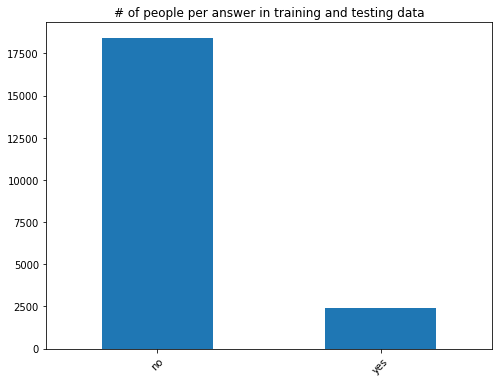

In [16]:
train_test_data['y'].value_counts().plot(kind='bar', figsize=(8,6))
plt.title("# of people per answer in training and testing data")
plt.xticks([0, 1], ['no', 'yes'], rotation=45)
plt.show()

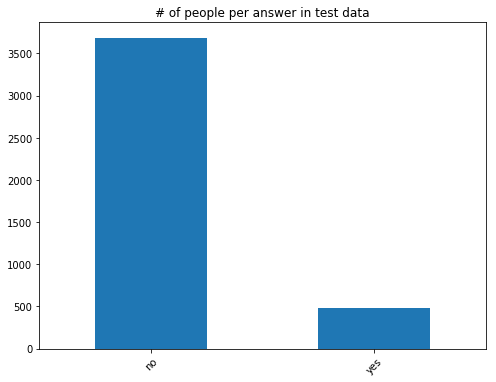

In [17]:
test_data['y'].value_counts().plot(kind='bar', figsize=(8,6))
plt.title("# of people per answer in test data")
plt.xticks([0, 1], ['no', 'yes'], rotation=45)
plt.show()

We need to adress the issue, that our data is higly unbalanced - the sample for 'yes' answers is significantly smaller than the amount of 'no' answers - this can lead to our classificator simply ignoring those positive answers.

The imbalance can be clearly seen on the histogram.

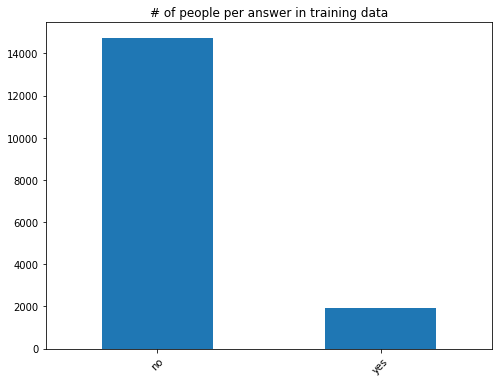

In [18]:
training_data['y'].value_counts().plot(kind='bar', figsize=(8,6))
plt.title("# of people per answer in training data")
plt.xticks([0, 1], ['no', 'yes'], rotation=45)
plt.show()

In [19]:
training_yes = training_data.loc[data['y'] == 1]
training_no  = training_data.loc[data['y'] == 0]

print("Number of " + str(training_yes['y'].value_counts()))
print("Number of " + str(training_no['y'].value_counts()))

Number of 1    1904
Name: y, dtype: int64
Number of 0    14735
Name: y, dtype: int64


In [20]:
training_yes_up = resample(training_yes, replace=True, n_samples=14735)

print("Number of " + str(training_yes_up['y'].value_counts()))
print("Number of " + str(training_no['y'].value_counts()))

Number of 1    14735
Name: y, dtype: int64
Number of 0    14735
Name: y, dtype: int64


Now we can concatenate the data back:

Index(['id', 'campaign', 'pdays', 'previous', 'y', 'age', 'b_year',
       'b_sin_month', 'b_cos_month', 'b_sin_day', 'b_cos_day', 'c_year',
       'c_sin_month', 'c_cos_month', 'c_sin_day', 'c_cos_day', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'contact_cellular', 'contact_telephone

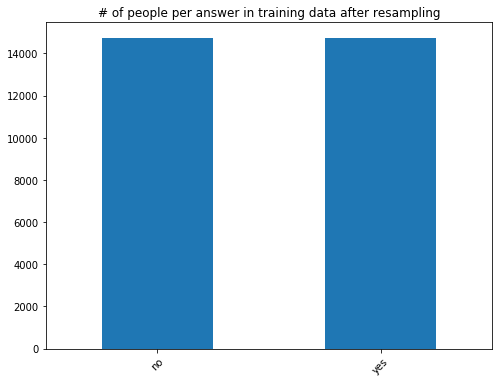

In [21]:
training_data = pd.concat([training_yes_up, training_no])

print(training_data.columns)

training_data['y'].value_counts().plot(kind='bar', figsize=(8,6))
plt.title("# of people per answer in training data after resampling")
plt.xticks([0, 1], ['no', 'yes'], rotation=45)
plt.show()

## Testing different models

Before we begin testing different models, we need to split data into our inputs and outputs

In [22]:
X = training_data.drop(['id', 'y'], axis=1).values
y = np.ravel(training_data[['y']].values)

id_test = test_data['id'].values
X_test = test_data.drop(['id', 'y'], axis=1).values
y_test = np.ravel(test_data['y'].values)

id_sub = submission_data['id'].values
X_sub = submission_data.drop(['id', 'y'], axis=1).values

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

cv = StratifiedKFold()

We'll also define a function for easier saving submission to .csv file:

In [23]:
def save_sub(name, y_sub, id_sub):
    subm_set = np.stack((id_sub.astype(int), y_sub), axis=1)
    np.savetxt("subm_" + name + ".csv", subm_set, delimiter=",", header="id,y", fmt="%d,%1.12f", comments="")

### RandomForestClassifier

In [24]:
param_grid = {'max_depth' : range(3, 10), 'min_samples_leaf': range(2, 7), 'min_samples_split': [2, 3]}

gs = GridSearchCV(RandomForestClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring=scoring, cv=cv, refit='AUC')
gs.fit(X, y)
results = gs.best_estimator_

In [25]:
y_pred = results.predict(X_test)
print("AUC score: %f" % (roc_auc_score(y_test, y_pred)))

AUC score: 0.745779


Saving results for submission:

In [235]:
y_sub = results.predict(X_sub)
save_sub("rfc", y_sub, id_sub)

### AdaBoost

In [28]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter"  : ["best", "random"],
              "n_estimators": range(100, 200, 20),
              "learning_rate" : [0.1, 0.5, 1.]}


dtc = DecisionTreeClassifier(random_state = 42, max_features = "auto", class_weight = "balanced", max_depth = None)

gs = GridSearchCV(AdaBoostClassifier(base_estimator = dtc),
                  param_grid=param_grid,
                  scoring=scoring, cv=cv, refit='AUC')

gs.fit(X, y)
results = gs.best_estimator_

In [29]:
y_pred = results.predict(X_test)
print("AUC score: %f" % (roc_auc_score(y_test, y_pred)))

AUC score: 0.613494


Saving results for submission:

In [222]:
y_sub = results.predict(X_sub)
save_sub("ada", y_sub, id_sub)

### GradientBoostingClassifier

In [31]:
param_grid = {"n_estimators": [500, 600],
              "learning_rate" : [0.1, 0.5, 1.]}

gs = GridSearchCV(GradientBoostingClassifier(),
                  param_grid=param_grid,
                  scoring=scoring, cv=cv, refit='AUC')

gs.fit(X, y)
results = gs.best_estimator_

In [32]:
y_pred = results.predict(X_test)
print("AUC score: %f" % (roc_auc_score(y_test, y_pred)))

AUC score: 0.644482


Saving results for submission:

In [232]:
y_sub = results.predict(X_sub)
save_sub("gbc", y_sub, id_sub)

### Neural Networks (fully connected)

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

seed = 42
np.random.seed(seed)

def nn_model():
    model = Sequential()
    model.add(Dense(26, input_dim=52, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Using Theano backend.
Using cuDNN version 6005 on context None
Mapped name None to device cuda: Graphics Device (0000:0E:00.0)


In [34]:
neural_net = nn_model()
neural_net.fit(X, y, epochs=20, batch_size=256)

Epoch 1/20
29470/29470 [==============================] - 3s - loss: 0.8044 - acc: 0.5336     
Epoch 2/20
29470/29470 [==============================] - 0s - loss: 0.6819 - acc: 0.5592     
Epoch 3/20
29470/29470 [==============================] - 0s - loss: 0.6672 - acc: 0.5931     
Epoch 4/20
29470/29470 [==============================] - 0s - loss: 0.6553 - acc: 0.6197     
Epoch 5/20
29470/29470 [==============================] - 0s - loss: 0.6420 - acc: 0.6357     
Epoch 6/20
29470/29470 [==============================] - 0s - loss: 0.6322 - acc: 0.6467     
Epoch 7/20
29470/29470 [==============================] - 0s - loss: 0.6301 - acc: 0.6440     
Epoch 8/20
29470/29470 [==============================] - 0s - loss: 0.6208 - acc: 0.6506     
Epoch 9/20
29470/29470 [==============================] - 0s - loss: 0.6244 - acc: 0.6463     
Epoch 10/20
29470/29470 [==============================] - 0s - loss: 0.6217 - acc: 0.6470     
Epoch 11/20
29470/29470 [========================

In [35]:
y_pred = neural_net.predict(X_test)
print("AUC score: %f" % (roc_auc_score(y_test, y_pred)))

AUC score: 0.738838


Saving results for submission:

In [189]:
y_sub = np.ravel(neural_net.predict(X_sub))
save_sub("nn", y_sub, id_sub)

### xgboost

I've run into some problems using xgboost with GridSearchCV (grid search was giving worse results than default settings of xgboost, even when they were included into parameters grid).

I've decided to try out things myself.

Creating matrix for our scores:

In [59]:
d, e = 9, 21

test_matrix = [[0 for x in range(e)] for y in range(d)]

In [60]:
for _ in range(0, 100):
    submission_data = data.loc[data['y'] == 2]
    train_test_data = data.loc[data['y'] != 2]

    sss = StratifiedShuffleSplit(test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(train_test_data, train_test_data['y']):
        training_data = train_test_data.iloc[train_index]
        test_data = train_test_data.iloc[test_index]

    training_yes = training_data.loc[data['y'] == 1]
    training_no  = training_data.loc[data['y'] == 0]
    training_yes_up = resample(training_yes, replace=True, n_samples=14735)
    training_data = pd.concat([training_yes_up, training_no])

    X = training_data.drop(['id', 'y'], axis=1).values
    y = np.ravel(training_data[['y']].values)

    id_test = test_data['id'].values
    X_test = test_data.drop(['id', 'y'], axis=1).values
    y_test = np.ravel(test_data['y'].values)

    id_sub = submission_data['id'].values
    X_sub = submission_data.drop(['id', 'y'], axis=1).values


    dtrain = xgb.DMatrix(X, label=y)

    param = {'max_depth': 2, 'eta': 0.15, 'silent': 1,
             'objective': 'binary:logistic', 'nthread' : 4,
             'eval_metric' : 'auc', 'seed': 42}
    num_round = 15
    
    for i in range(4, 8):
        for j in np.arange(0.15, 0.2, 0.01):
            param['max_depth'] = i
            param['eta'] = j

            bst = xgb.train(param, dtrain, num_round)

            dtest = xgb.DMatrix(X_test)
            y_pred = bst.predict(dtest)
            result = roc_auc_score(y_test, y_pred)

            if (result > 0.799):
                test_matrix[i][(j * 100).astype(int)] = test_matrix[i][(j * 100).astype(int)] + 1
               
            if (result < 0.78):
                test_matrix[i][(j * 100).astype(int)] = test_matrix[i][(j * 100).astype(int)] - 1

In [70]:
plot_matrix = np.array(test_matrix)
plot_matrix[4:8,15:21]

array([[24, 28, 32, 35, 27, 28],
       [39, 45, 47, 43, 36, 40],
       [44, 41, 44, 40, 42, 33],
       [25, 27, 21, 23, 28, 19]])

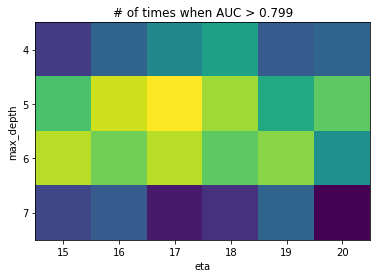

In [80]:
plt.imshow(plot_matrix[4:8,15:21], aspect='auto')
plt.title("# of times when AUC > 0.799")
plt.xticks(range(0, 6), range(15, 21))
plt.yticks(range(0, 4), range(4, 9))
plt.ylabel('max_depth')
plt.xlabel('eta')
plt.show()

While testing it the above way, the best results were achieved with max depth of 5, and eta of 17:

In [81]:
dtrain = xgb.DMatrix(X, label=y)

param = {'max_depth': 5, 'eta': 0.17, 'silent': 1,
         'objective': 'binary:logistic', 'nthread' : 4,
         'eval_metric' : 'auc', 'seed': 42}

num_round = 15
bst = xgb.train(param, dtrain, num_round)

In [82]:
dtest = xgb.DMatrix(X_test)

y_pred = bst.predict(dtest)
print("AUC score: %f" % (roc_auc_score(y_test, y_pred)))

AUC score: 0.800154


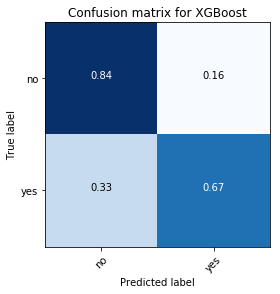

In [83]:
classes = ['no', 'yes']
bst_conf = confusion_matrix(y_test, np.rint(y_pred))

# normalization
bst_conf = bst_conf.astype('float') / bst_conf.sum(axis=1)[:, np.newaxis]

plt.imshow(bst_conf, cmap=plt.cm.Blues)
plt.title("Confusion matrix for XGBoost")
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(bst_conf.shape[0]), range(bst_conf.shape[1])):
    plt.text(j, i, format(bst_conf[i, j], ".2f"), horizontalalignment="center",
             color="white" if bst_conf[i, j] > 0.5 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

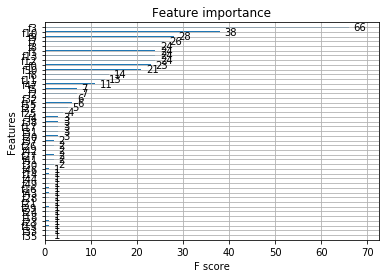

In [84]:
xgb.plot_importance(bst)
plt.show()

In [85]:
dsub = xgb.DMatrix(X_sub)
y_sub = bst.predict(dsub)
save_sub("xgb_best", y_sub, id_sub)